In [1]:
import gurobipy as gp
from gurobipy import GRB
import pandas as pd

# -----------------------------
# Index Sets
# -----------------------------

file_path = "Dataset.xlsx"  

# Read sheet "City"
Index_Details = pd.read_excel(file_path, sheet_name="City")
Distance_Matrix = pd.read_excel(file_path, sheet_name="Distance Matrix")
Chennai = pd.read_excel(file_path, sheet_name="Chennai")
Visit_Duration = pd.read_excel(file_path, sheet_name="Visit Duration")
Avg_Stay = pd.read_excel(file_path, sheet_name="Avg Stay")

# Extract A and T from columns "Index" and "Time"
A = Index_Details["Index"].dropna().astype(int).tolist()
T = Index_Details["Time"].dropna().astype(int).tolist()
# A = [0, 1, 2, 3]       # Set of all places at a station (0 = hub, rest = tourist spots)
# T = [1, 2]             # Set of days

# -----------------------------
# Parameters
# -----------------------------
Q = 10  # Daily hours available per day

# Travel times t^s_ij (hours) between locations i and j
t_time = Chennai.set_index(['from_index', 'to_index'])['Travel Time (hours)'].to_dict()

# give large value for self-loops (to avoid divide by zero in objective)
for i in A:
    t_time[i,i] = 1e6

# Roaming time (tv_j^s) at each location j
tv = Visit_Duration.set_index(['Index'])['time'].to_dict()

# Average travel+stay time q_i (used in MTZ)
q = Avg_Stay.set_index(['Index'])['avg_time'].to_dict()

# -----------------------------
# Model
# -----------------------------
model = gp.Model("Tour_MILP")

# -----------------------------
# Decision Variables
# -----------------------------
# x_ijt : binary, 1 if tourist travels from i to j on day t
x = model.addVars(A, A, T, vtype=GRB.BINARY, name="x")

# x_t : binary, 1 if travel is suggested on day t
x_day = model.addVars(T, vtype=GRB.BINARY, name="xday")

# u_i : MTZ auxiliary variable for subtour elimination
u = model.addVars(A, vtype=GRB.CONTINUOUS, lb=0.0, ub=Q, name="u")

# -----------------------------
# Objective (1)
# -----------------------------
model.setObjective(
    gp.quicksum(x[i,j,t] / t_time[i,j] for i in A for j in A for t in T if i != j),
    GRB.MAXIMIZE
)

# -----------------------------
# Constraints
# -----------------------------
# (2) No self-loops
for i in A:
    model.addConstr(gp.quicksum(x[i,i,t] for t in T) == 0, name=f"no_self_{i}")

# (3) Flow conservation per day
for j in A:
    for t in T:
        model.addConstr(
            gp.quicksum(x[i,j,t] for i in A) == gp.quicksum(x[j,k,t] for k in A),
            name=f"flow_{j}_{t}"
        )

# (4) Visit each non-hub at most once over all days
for j in [a for a in A if a != 0]:
    model.addConstr(
        gp.quicksum(x[i,j,t] for i in A for t in T if i != j) <= 1,
        name=f"visit_once_{j}"
    )

# (5) Start trip from hub
for t in T:
    model.addConstr(
        gp.quicksum(x[0,j,t] for j in A) == x_day[t],
        name=f"start_hub_{t}"
    )

# (6) Daily time budget (travel + roaming)
for t in T:
    model.addConstr(
        gp.quicksum(x[i,j,t] * (t_time[i,j] + tv[j])
                    for i in A if i != 0
                    for j in A if j != 0) <= Q,
        name=f"time_budget_{t}"
    )

# (7) Prioritize earlier days
for idx in range(len(T)-1):
    model.addConstr(x_day[T[idx]] >= x_day[T[idx+1]], name=f"priority_{T[idx]}")

# (8) Binary domains already set by variable types

# (9) MTZ subtour elimination
for i in [a for a in A if a != 0]:
    for j in [a for a in A if a != 0]:
        if i != j:
            for t in T:
                model.addConstr(
                    u[j] - u[i] >= q[i] - Q * (1 - x[i,j,t]),
                    name=f"mtz_{i}_{j}_{t}"
                )

# (10) MTZ lower bound (interpreted as u_i >= q_i)
for i in [a for a in A if a != 0]:
    model.addConstr(u[i] >= q[i], name=f"mtz_lb_{i}")

# (11) MTZ upper bound
for i in A:
    model.addConstr(u[i] <= Q, name=f"mtz_ub_{i}")

# -----------------------------
# Solve
# -----------------------------
model.optimize()

# -----------------------------
# Results
# -----------------------------
# if model.status == GRB.OPTIMAL:
#     print("\nOptimal Objective Value:", model.objVal)
#     print("\nDay decisions:")
#     for t in sorted(T):
#         if x_day[t].X > 0.5:
#             print(f" Day {t}: Travel")
#     print("\nArcs chosen:")
#     for t in sorted(T):
#         for i in A:
#             for j in A:
#                 if x[i, j, t].X > 0.5:
#                     print(f" Day {t}: {i} -> {j}")
#     print("\nMTZ u-values:")
#     for i in A:
#         print(f" u[{i}] = {u[i].X:.2f}")
# -----------------------------
# Results (pretty print like Tabu Search)
# -----------------------------
if model.status == GRB.OPTIMAL:
    print("\n=== MILP RESULT (Gurobi) ===")
    print("Optimal Objective Value:", model.objVal)

    # Build routes per day
    routes = {}
    for t in sorted(T):
        # build adjacency list
        succ = {}
        for i in A:
            for j in A:
                if i != j and x[i,j,t].X > 0.5:
                    succ[i] = j
        # reconstruct path starting at hub if any route exists
        route = [0]
        while route[-1] in succ:
            route.append(succ[route[-1]])
            if route[-1] == 0:  # returned to depot
                break
        routes[t] = route

    # Print per-day details
    for t in sorted(T):
        r = routes.get(t, [0])
        if len(r) <= 1 or (len(r) == 2 and r == [0,0]):
            continue  # no travel that day
        print(f"\nDay {t}:")
        print(" Route:", " -> ".join(map(str, r)))

        # compute time
        total_time = 0.0
        total_cost = 0.0
        for a, b in zip(r[:-1], r[1:]):
            total_time += t_time[a, b]
            if b != 0:
                total_time += tv[b]
            if t_time[a, b] < 1e5:
                total_cost += 1.0 / t_time[a, b]
        print(f" Time: {total_time:.2f} / {Q}")
        print(f" Cost: {total_cost:.6f}")
        print(" Arcs:")
        for a, b in zip(r[:-1], r[1:]):
            print(f"  {a} -> {b}")

    # Print MTZ values too (optional)
    print("\nMTZ u-values:")
    for i in A:
        print(f" u[{i}] = {u[i].X:.2f}")


Set parameter Username
Set parameter LicenseID to value 2595033
Academic license - for non-commercial use only - expires 2025-12-03
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (win64 - Windows 11.0 (26100.2))

CPU model: AMD Ryzen 5 4600H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 169 rows, 173 columns and 937 nonzeros
Model fingerprint: 0xf70feb4c
Variable types: 9 continuous, 164 integer (164 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+06]
  Objective range  [3e-01, 2e+01]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 1e+01]
Found heuristic solution: objective -0.0000000
Presolve removed 42 rows and 42 columns
Presolve time: 0.03s
Presolved: 127 rows, 131 columns, 1488 nonzeros
Variable types: 8 continuous, 123 integer (123 binary)

Root relaxation: objective 8.895322e+01, 48 iterations, 0.01 seconds (0.00 work units)

    Nodes    |   

C:\Users\Shubham\AppData\Local\Temp\ipykernel_4224\143996126.py:40: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


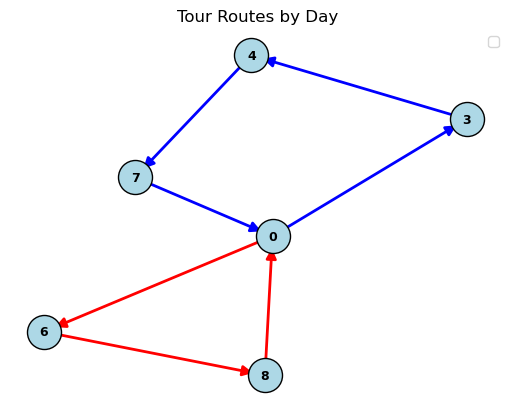

In [2]:
import matplotlib.pyplot as plt
import networkx as nx
# Build arcs_by_day from solution
arcs_by_day = {}
for t in sorted(T):
    arcs_by_day[t] = [(i, j) for i in A for j in A if x[i, j, t].X > 0.5]


# Collect all nodes
A = {i for arcs in arcs_by_day.values() for edge in arcs for i in edge}

# Build a directed graph
G = nx.DiGraph()
G.add_nodes_from(A)
for arcs in arcs_by_day.values():
    G.add_edges_from(arcs)

# Auto layout (no overlaps, nice spacing)
pos = nx.spring_layout(G, seed=42)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=600, node_color="lightblue", edgecolors="black")
nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")

# Colors for days
colors = ["red", "blue", "green", "orange", "purple", "brown"]

# Draw arcs by day
for idx, (t, arcs) in enumerate(sorted(arcs_by_day.items())):
    nx.draw_networkx_edges(
        G, pos,
        edgelist=arcs,
        edge_color=colors[idx % len(colors)],
        arrows=True,
        arrowsize=15,
        width=2,
        label=f"Day {t}"
    )

plt.legend()
plt.title("Tour Routes by Day")
plt.axis("off")
plt.show()
